In [119]:
import pandas as pd

# prophet
from prophet import Prophet
from prophet.plot import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

# warnings
import warnings
warnings.filterwarnings('ignore')

In [120]:
# importar dados
df_ipea = pd.read_csv('/content/drive/MyDrive/PosTech_Analise_de_dados/FASE4/tech_challenge_4/dados/ipeadata_limpo.csv')
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11188 entries, 0 to 11187
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   data                  11188 non-null  object 
 1   valor                 11188 non-null  float64
 2   percentual            11188 non-null  float64
 3   ano                   11188 non-null  int64  
 4   decada                11188 non-null  int64  
 5   var_pct_ano_anterior  11187 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 524.6+ KB


In [121]:
df_ipea['data'] = pd.to_datetime(df_ipea['data'])

In [122]:
df_ipea.drop(['var_pct_ano_anterior', 'decada', 'ano'], axis=1, inplace=True)

In [123]:
df_ipea.set_index('data', inplace=True)

In [124]:
df_ipea.dtypes

valor         float64
percentual    float64
dtype: object

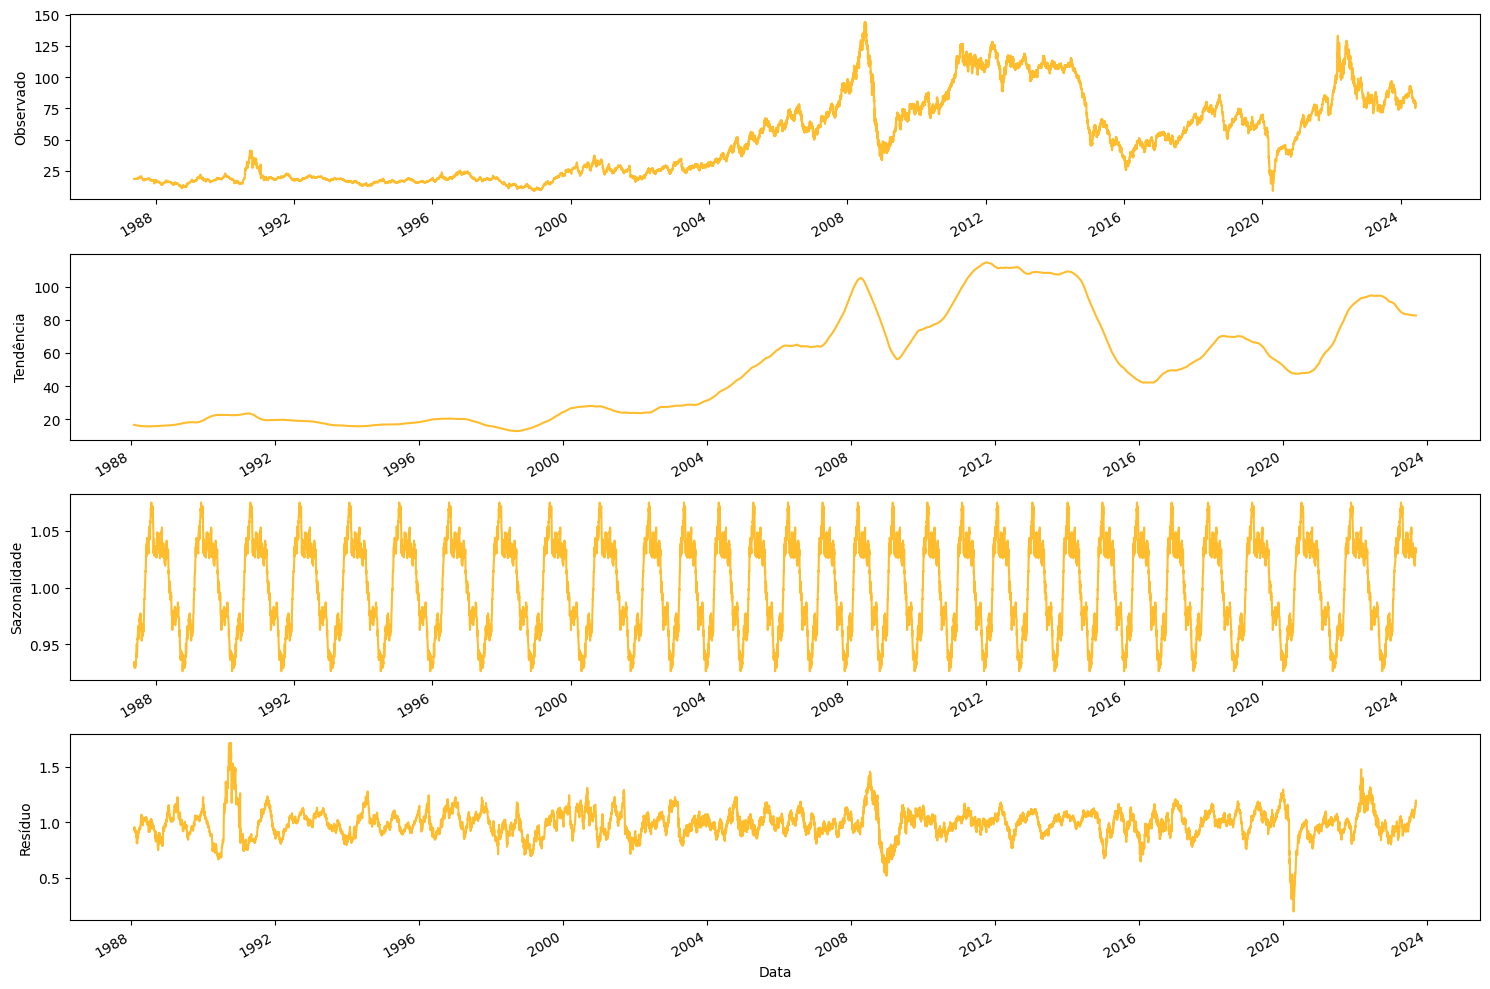

In [125]:
# Realizar a decomposição
result = seasonal_decompose(df_ipea['valor'], model='multiplicative', period=365)

# Plotar os componentes da decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

color_fig='#FFBD2D'

result.observed.plot(ax=ax1, color=color_fig)
ax1.set_ylabel('Observado')
ax1.set_xlabel('')
ax1

result.trend.plot(ax=ax2, color=color_fig)
ax2.set_ylabel('Tendência')
ax2.set_xlabel('')

result.seasonal.plot(ax=ax3, color=color_fig)
ax3.set_ylabel('Sazonalidade')
ax3.set_xlabel('')

result.resid.plot(ax=ax4, color=color_fig)
ax4.set_ylabel('Resíduo')
ax4.set_xlabel('Data')

plt.tight_layout()
plt.show()

# 4 anos

In [127]:
df_ipea.reset_index(inplace=True)

In [128]:
prophet_df_ipea = df_ipea[df_ipea['data'] >= df_ipea['data'].max() - pd.DateOffset(years=4)]
prophet_df_ipea.rename(columns={'data': 'ds','valor': 'y'}, inplace=True)

In [130]:
prophet_df_ipea.dtypes

ds            datetime64[ns]
y                    float64
percentual           float64
dtype: object

In [131]:
train_ipea = prophet_df_ipea.sample(frac=0.8, random_state=0)
test_ipea = prophet_df_ipea.drop(train_ipea.index)
print(f'train: {train_ipea.shape}')
print(f'test: {test_ipea.shape}')

train: (814, 3)
test: (203, 3)


In [132]:
# Instanciando o Modelo
prophet = Prophet(daily_seasonality=True)

# Treinando o Modelo
prophet.fit(train_ipea)

# Realizando a Previsão 120 dias (4 meses)
df_ipea_prophet = prophet.make_future_dataframe(periods=120, freq='B')
prev_prophet = prophet.predict(df_ipea_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdh8n9arl/rsq2pz2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdh8n9arl/5ydicext.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15875', 'data', 'file=/tmp/tmpdh8n9arl/rsq2pz2f.json', 'init=/tmp/tmpdh8n9arl/5ydicext.json', 'output', 'file=/tmp/tmpdh8n9arl/prophet_modelfg_ow0lu/prophet_model-20240619025429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


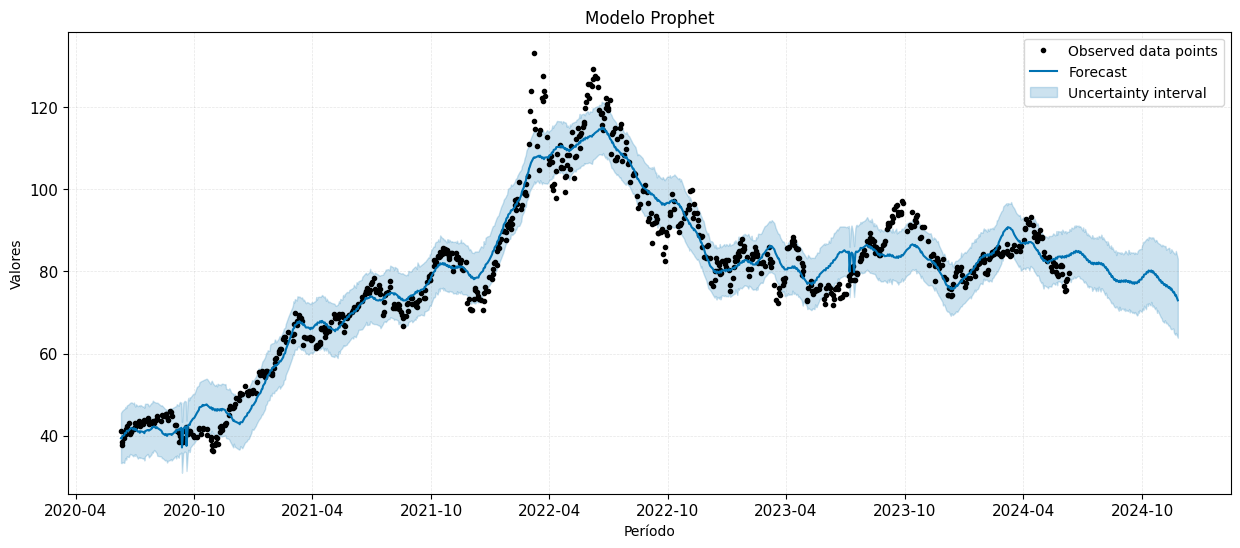

In [133]:
plt.figure(figsize=(15,6))
prophet.plot(prev_prophet, xlabel='Período', ylabel='Valores', ax=plt.gca())
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Modelo Prophet', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

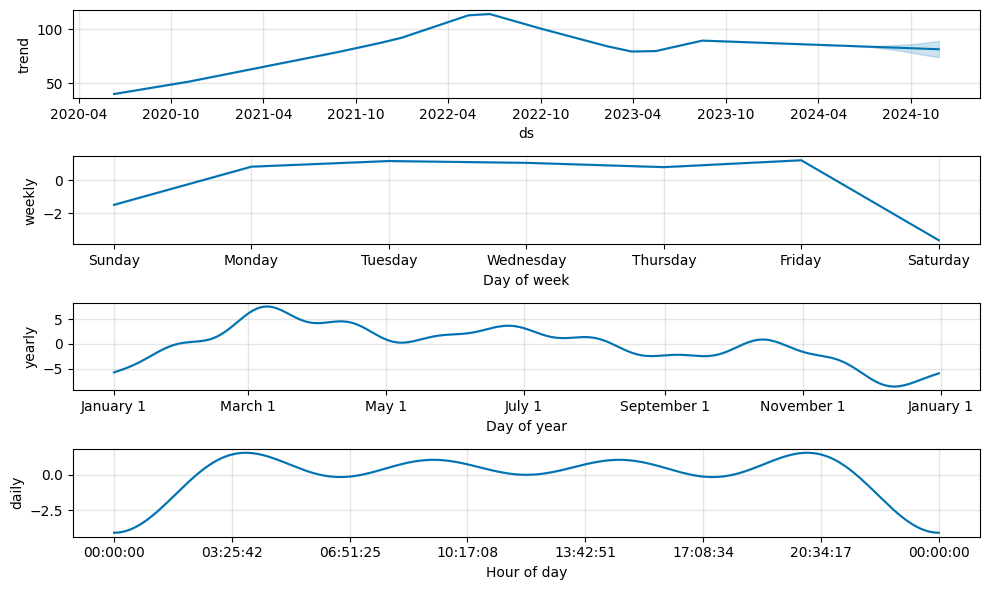

In [134]:
prophet.plot_components(prev_prophet, figsize=(10,6))
plt.show()

In [135]:
# Resultados para calcular resultados
result = pd.merge(prev_prophet[['ds', 'yhat']], train_ipea[['ds', 'y']], on='ds', how='inner')

y_result = result['y']
yhat_result = result['yhat']

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_result, yhat_result)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_result, yhat_result)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_result, yhat_result)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_result - yhat_result) / y_result)) * 100

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 23.11
MAE: 3.66
R²: 0.94
MAPE: 4.80%
